# Historical Donor Data - Cleaning 

**Who**
All individual donors who gave to the c3 recorded in NGP, minus monthly donors. We have  
We’re working with 2,329 donors in this analysis.

**Approach**
This is what I would call an “exploratory data analysis.” My goal here was to simply understand or donor data and start asking questions. Like every good analysis, I wound up with more questions than I was able to answer.   

**I started my analysis by asking the questions:**  
How many of our donors give below \\$100? Below \\$500? Below \\$1,000?  
What’s the average lifetime value of our donors?  
How many of our donors give once and then never again?  
Who loves us the most (donors with the most gifts)?  


In [1]:
# load the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
datetime.datetime.strptime

%matplotlib inline

In [2]:
# read in the data for the c4 and the c3
c3 = pd.read_csv("data/all_c3_donors.Csv")
c4 = pd.read_csv("data/all_c4_donors.csv")

# Data Cleaning  

I just joined this organization and had never touched their data before, so I had no idea what I was getting myself into. I had a vague understanding that our data were messy, incomplete, and just plain bad, so I decided to poke around and see for myself.

## The Data  

We start, as always, by reading in the data and taking a look. Since you are reading this over the Internet, I have made the donor data anonymous.

In [3]:
# Let's make the donors anonymous 
c3_small = c3.iloc[:,[2,3,11]]
c3_small.columns = ['date', 'amount', 'name']
c3_small["name"] = c3_small["name"].astype('category').cat.codes
c3_small.head(10)

/home/thebbennett/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,date,amount,name
0,06/15/2013,25.0,1900
1,07/08/2011,2000.0,4112
2,09/03/2013,25.0,4182
3,10/11/2013,100.0,1966
4,09/03/2013,25.0,1973
5,09/03/2013,10.0,2004
6,09/13/2013,1.0,2028
7,05/15/2014,10.0,2145
8,08/26/2014,10.0,2145
9,09/02/2013,5.0,4367


The above table lists individual donations by transaction date, but as a fundraiser I'm interested in donors themselves. I grouped the data above my name and summed their total contribution amounts to get their "lifetime value."

In [4]:
# What are the lifetime amounts of our top donors?
donors_by_lifetime = c3_small.groupby(['name'])['amount'].sum().sort_values(ascending = False).to_frame()
donors_by_lifetime.columns = ['lifetime_amount']
donors_by_lifetime.head(15)

,lifetime_amount
name,
4421,301000.0
673,50000.0
5780,50000.0
6974,35500.0
813,35000.0
6980,35000.0
3537,30555.0
1456,26100.0
6093,25000.0


I was told that my org championed an international Indiegogo campaign that garnered 6,000+ donors. While this is awesome, as a fundraise I know this will heavily skew our retention rates. I know that we really only have 2,000 or so active donors, so carrying around 6,000 one-time donors we'll never be able to contact again isn't useful for our work.  

The only issue is, I had no idea how these donors were coded into our database, if at all.  

But before we begin, let's see what the distribution is for all giving.

In [5]:
# create a separate dataframe for small dollar donors
sub_100 = donors_by_lifetime.loc[donors_by_lifetime["lifetime_amount"] <= 100]

[Text(0,0.5,'Frequency'), Text(0.5,0,'Lifetime Value ($)')]

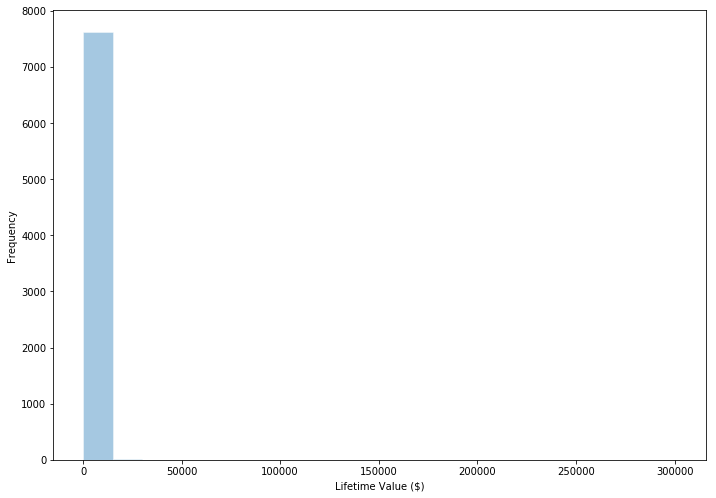

In [6]:
# Plot a histogram of all donor lifetime value, for the heck of it
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_style('white')

sns.distplot(donors_by_lifetime['lifetime_amount'], bins = 20, kde = False)
ax.set(xlabel='Lifetime Value ($)', ylabel='Frequency')


No matter the number of bins, this graph looks the same. We overwhelmingly have small dollar gifts in this unclean data set. 

Let's look only at small dollar donors (donors with lifetime values under \\$100)

[Text(0,0.5,'Frequency'), Text(0.5,0,'Lifetime Value ($)')]

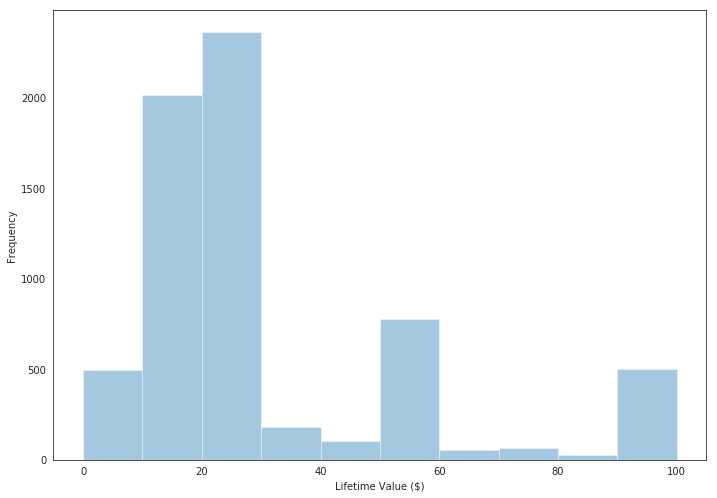

In [7]:
# Plot a histogram of small dollar donors and their lifetime values
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set_style('white')
#sns.set_context("poster")

sns.distplot(sub_100['lifetime_amount'], bins = 10, kde = False)
ax.set(xlabel='Lifetime Value ($)', ylabel='Frequency')


In [8]:
sub_100.loc[sub_100['lifetime_amount'] >= 25].count()

lifetime_amount    3677
dtype: int64

In [9]:
donors_by_lifetime.loc[donors_by_lifetime["lifetime_amount"] == 25].count()/len(donors_by_lifetime)

lifetime_amount    0.255166
dtype: float64

With a zoomed in data set, we see that we have thousands of donors with lifetime values \\$25 or below -- 3,677 of them (or 25.5\%!) in fact. I bet that these are our Indiegogo folk, so let's look at removing these donor from the analysis.

## Removing the One Time Indiegogo Folk

We start by making a fresh, clean dataframe and calling it "c3_clean". This definitely won't become cumbersome later on.  



In [10]:
c3_clean = c3
c3_clean[" Contact Name"] = c3_clean[" Contact Name"].astype('category').cat.codes
c3_clean = c3_clean.set_index(" Contact Name")


In [11]:
c3_clean["Received On"] = pd.to_datetime(c3_clean["Received On"])


In [12]:
c3_clean.columns

Index(['Count', 'Contribution ID', 'Received On', 'Amount', 'Designation',
       'Contribution Type', 'Cycle', 'Period', 'Contribution.Note',
       ' Source Code Path', ' Contact ID'],
      dtype='object')

By plotting the gifts over time, we easily spoot the Indiegogo campaign: 2013. Let's zero in on that year.

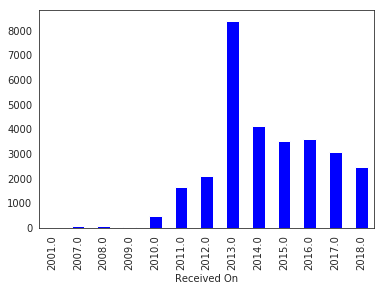

In [13]:
c3_clean.groupby(c3_clean["Received On"].dt.year).Amount.count().plot(kind="bar", color = 'blue')


We can plot a bar graph of 2013 once we've segmented out the 2013 donors.

In [14]:
donors_2013 = c3_clean[c3_clean['Received On'].apply(lambda x: x.year == 2013)]


Bingo. The crowdfunding campaign occured in September of 2013.

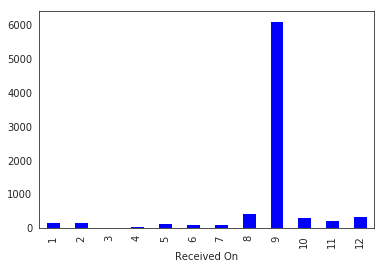

In [23]:
donors_2013.groupby(donors_2013["Received On"].dt.month).Amount.count().plot(kind="bar", color = 'blue')


There were a whopping 6,128 donors during the Indiegogo campaign! We can now filter out these donors from the original dataframe to build our c3_clean dataframe.

In [16]:
indiegogo = donors_2013[donors_2013['Received On'].apply(lambda x: x.month == 9)]
len(indiegogo)

6128

In [17]:
i1 = c3_clean.index
i2 = indiegogo.index
c3_clean = c3_clean[~i1.isin(i2)]

## Removing monthly donors  

We don't want to include monthly donors when computing statistics like retention rate or attrition, as they heavily skew the data. Let's create a separate csv for monthly donors and analyze them separately, and keep the future historical donor analysis for one-time donors.  

Monthly donations have the source code "Player contribution", so we can search the source code path column for mentions of 'player'. 

In [19]:
monthly_gifts = c3_clean[c3_clean[' Source Code Path'].str.contains("Player") == True]
monthly_gifts.head()

,Count,Contribution ID,Received On,Amount,Designation,Contribution Type,Cycle,Period,Contribution.Note,Source Code Path,Contact ID
Contact Name,,,,,,,,,,,
3344,NaN,VNW16EPKCJ9,2016-08-15,5.0,New Era Colorado Foundation,Monetary Contribution,NaN,NaN,NaN,c3 Donors/Player contribution,VNX0EGHJ7D6
3903,NaN,VNW16E2V624,2015-11-15,5.0,New Era Colorado Foundation,Monetary Contribution,NaN,Primary,NaN,c3 Donors/Player contribution,VNX0EGH8D82
3353,NaN,VNW16DM0RJ5,2015-02-15,5.0,New Era Colorado Foundation,Monetary Contribution,NaN,NaN,NaN,c3 Donors/Player contribution,VNX0EGJ17E3
3353,NaN,VNW16DQ6KD7,2015-05-15,5.0,New Era Colorado Foundation,Monetary Contribution,NaN,NaN,NaN,c3 Donors/Player contribution,VNX0EGJ17E3
3353,NaN,VNW16DN7177,2014-12-15,5.0,New Era Colorado Foundation,Monetary Contribution,NaN,NaN,NaN,c3 Donors/Player contribution,VNX0EGJ17E3


Let's save out this dataframe and then filter these transactions out from our clean dataframe.

In [26]:
#save the dataframe to a csv
monthly_gifts.to_csv("data/monthly.csv")

In [28]:
# create a new dataframe that contains no monthly gifts
no_monthly = pd.concat([c3_clean, monthly_gifts]).drop_duplicates(keep=False)


In [29]:
# save the new dataframe as a csv
no_monthly.to_csv("data/historical_data.csv")

# Wrapping It Up  

Let's take a look at some summaries below to check our work. 


In [30]:
no_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6420 entries, 4112 to -1
Data columns (total 11 columns):
Count                1 non-null float64
Contribution ID      6419 non-null object
Received On          6419 non-null datetime64[ns]
Amount               6419 non-null float64
Designation          6419 non-null object
Contribution Type    6419 non-null object
Cycle                0 non-null float64
Period               0 non-null object
Contribution.Note    5 non-null object
 Source Code Path    4582 non-null object
 Contact ID          6419 non-null object
dtypes: datetime64[ns](1), float64(3), object(7)
memory usage: 601.9+ KB


In [31]:
no_monthly.describe()

,Count,Amount,Cycle
count,1.0,6419.000000,0.0
mean,29613.0,195.870050,NaN
std,NaN,2411.450474,NaN
min,29613.0,1.000000,NaN
25%,29613.0,10.000000,NaN
50%,29613.0,15.000000,NaN
75%,29613.0,50.000000,NaN
max,29613.0,100000.000000,NaN
